# Weakly Supervised Disease Score

## Import

In [1]:
import sys
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt


from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm 
from ast import literal_eval
from scipy.spatial.distance import cosine
from scipy.stats.stats import pearsonr   
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.autograd import Variable
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error

## Configs

In [2]:
EXPERIMENTS = ['HRCE-1', 'HRCE-2']
PLATE_NUMBERS = {
    'HRCE-1': 26,
    'HRCE-2': 27
}

## Data Paths

In [3]:
DATA_PATH = '../../data'
FEATURES_PATH = os.path.join('../..', 'features')
CP_NORMAL_FILE = 'normalized_well_profile.csv'
METADATA_PATH = os.path.join(DATA_PATH, 'metadata.csv')
WELL_CELL_COUNTS_PATH = os.path.join(DATA_PATH, 'significant_replicates', 'cell_count.csv')

## Load and Prepare Dataset

In [4]:
def load_profiles(experiments, plate_numbers, profile_name, drop_cols=[]):
    profiles = []
    for experiment in experiments:
        for i in tqdm(range(1, plate_numbers[experiment]+1)):
            data_path = os.path.join(
                FEATURES_PATH, experiment, 'Plate'+str(i), profile_name)
            profile = pd.read_csv(data_path)
            if 'well_id' not in profile.columns: print(i)
            profiles.append(profile)
    profiles = (
        pd.concat(profiles, axis=0, join='inner').drop(drop_cols, axis=1)
    ).dropna(axis=1)
    granularity_columns = [x for x in profiles.columns if ('Granularity' in x)]
    profiles = profiles.drop(granularity_columns, axis=1)
    return profiles

In [5]:
profiles = load_profiles(EXPERIMENTS, PLATE_NUMBERS, CP_NORMAL_FILE, drop_cols=['label', 'groupid'])
profiles.shape

100%|██████████████████████████████████████████████████████████████████████████████| 27/27 [00:20<00:00,  1.33it/s]


(71013, 2329)

In [6]:
def load_metadata(metadata_path, experiments):
    def label(disease_condition):
        if  disease_condition == 0: return 'negctrl'
        else: return 'posctrl'
    metadata = pd.read_csv(metadata_path)    
    metadata = metadata[metadata.experiment.isin(experiments)]
    metadata.treatment = metadata.treatment.str.lower()
    metadata = metadata[['treatment', 'treatment_conc' , 'well_id', 'disease_condition']]
    metadata = metadata.fillna(0)
    metadata['label'] = metadata.apply(lambda row: label(row.disease_condition), axis=1)
    metadata = metadata.assign(
        groupid = metadata.groupby(
            ['treatment', 'treatment_conc', 'disease_condition']).ngroup())
    metadata = metadata.assign(
        treatmentid = metadata.groupby(
            ['treatment', 'disease_condition']).ngroup())
    return metadata

In [7]:
metadata = load_metadata(METADATA_PATH, EXPERIMENTS).set_index('well_id')

In [8]:
def add_metadata_to_profiles(metadata, profiles):
    return (
        metadata.join(profiles.set_index('well_id'), how='inner')
        .drop_duplicates()
    )

In [9]:
profiles_with_meta = add_metadata_to_profiles(metadata, profiles)
profiles_with_meta.shape

(71013, 2334)

In [17]:
well_cell_counts = pd.read_csv(WELL_CELL_COUNTS_PATH)
toxic_wells = well_cell_counts[well_cell_counts.cell_count < 75].well_id.unique()
len(toxic_wells)

2677

In [18]:
toxics = (
    profiles_with_meta[profiles_with_meta.index.isin(toxic_wells)]
    .drop(metadata.columns, axis=1)
)

non_toxics = profiles_with_meta[~profiles_with_meta.index.isin(toxic_wells)]


ctrls = (
    non_toxics[non_toxics.label == 'negctrl']
    .drop(metadata.columns, axis=1)
)

active_sars = (
    non_toxics[
        (non_toxics.disease_condition == 'Active SARS-CoV-2') &
        (non_toxics.treatment == 0)
    ]
).drop(metadata.columns, axis=1)

mocks  = (
    non_toxics[non_toxics.disease_condition == 'Mock']
    .drop(metadata.columns, axis=1)
)

UV_inactive_sars = (
    non_toxics[
    non_toxics.disease_condition == 'UV Inactivated SARS-CoV-2']
    .drop(metadata.columns, axis=1)
)

treatments = (
    profiles_with_meta[profiles_with_meta.treatment != 0]
    .drop(metadata.columns, axis=1)
)

features = profiles.set_index('well_id')

treatments.shape, active_sars.shape, mocks.shape, UV_inactive_sars.shape, ctrls.shape, features.shape

((61693, 2328),
 (3377, 2328),
 (2107, 2328),
 (2108, 2328),
 (1172, 2328),
 (71013, 2328))

## PCA Whitening

In [19]:
pca = PCA(n_components=1024, whiten=True).fit(ctrls)

In [20]:
tvn_treatments = pd.DataFrame(pca.transform(treatments), index=treatments.index)
tvn_actives = pd.DataFrame(pca.transform(active_sars), index=active_sars.index)
tvn_mocks = pd.DataFrame(pca.transform(mocks), index=mocks.index)
tvn_uvs = pd.DataFrame(pca.transform(UV_inactive_sars), index=UV_inactive_sars.index)
tvn_ctrls = pd.DataFrame(pca.transform(ctrls), index=ctrls.index)
tvn_toxics = pd.DataFrame(pca.transform(toxics), index=toxics.index)


tvn_features = pd.concat(
    [tvn_treatments, tvn_actives, tvn_mocks, tvn_uvs, tvn_ctrls, tvn_toxics], axis=0
)
tvn_features.shape

(73127, 1024)

## Dataset

In [21]:
dist_std = profiles.set_index('well_id').std()
dist_mean = profiles.set_index('well_id').mean()

In [22]:
def gram_schmit(v, u):
    scale = np.dot(v, u.T)/np.dot(u, u.T)
    v_prime = v - u*scale
    return v_prime

In [23]:
def generate_random_noise(mean, std):
    noise = []
    for i in range(len(mean)):
        noise.append(np.random.normal(mean[i],std[i]))
    return pd.Series(noise).values

In [24]:
def get_dataset(pca, positive_features, negative_features, augment_size=0, mean=None, std=None):
    positive_labels = np.ones(len(positive_features))
    negative_labels = np.zeros(len(negative_features))

    augmented_features = []
    aug_labels = []
    pos_mean = positive_features.mean()
    neg_mean = negative_features.mean()
    
    for i in tqdm(range(augment_size)):
        alpha = random.random()
        
        neg = negative_features.sample().mean().values
        pos = positive_features.sample().mean().values 
        aug_feature = alpha*pos + (1-alpha)*neg
        
#         if random.random() > 0.5:
        beta = random.random()
        noise = generate_random_noise(mean, std)
        orthogonal_noise = gram_schmit(noise, pos_mean-neg_mean)
        if np.any(np.isnan(orthogonal_noise)):
            aug_feature += (orthogonal_noise*beta)
            
        augmented_features.append(aug_feature)
        aug_labels.append(alpha)
        
    x = pd.concat([positive_features, negative_features, 
        pd.DataFrame(augmented_features, columns=positive_features.columns)], axis=0)
    y = np.concatenate([positive_labels, negative_labels, aug_labels])
    return pca.transform(x), y

neg_controls_features = pd.concat([mocks, ctrls], axis=0)
pos_controls_features = pd.concat([active_sars, toxics], axis=0)

train_x, train_y = get_dataset(
    pca, pos_controls_features, neg_controls_features, augment_size=5000, mean=dist_mean, std=dist_std)
test_x, test_y = get_dataset(
    pca, active_sars.sample(), UV_inactive_sars)
len(train_x), len(test_x)

100%|██████████████████████████████████████████████████████████████████████████| 5000/5000 [01:28<00:00, 56.39it/s]
0it [00:00, ?it/s]


(14326, 2109)

In [25]:
traindataset = TensorDataset(
        torch.tensor(train_x).float(),
        torch.from_numpy(train_y).float()
    )

testdataset = TensorDataset(
        torch.tensor(test_x).float(),
        torch.from_numpy(test_y).float()
    )

In [26]:
traindataset, valdataset = torch.utils.data.random_split(traindataset, [12326, 2000])

In [27]:
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=64, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=1, shuffle=True, num_workers=1)
valloader = torch.utils.data.DataLoader(valdataset, batch_size=1, shuffle=True, num_workers=1)

## Train and Test

### MLP

In [28]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(1024, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32, 1), 
        )

    def forward(self, x):
        return self.layers(x)

In [29]:
def loss_function(output, alpha):
    output = torch.sigmoid(output)
    loss = nn.MSELoss()
    w_loss = loss(output.reshape(-1), alpha.reshape(-1))
    return w_loss

In [30]:
def cuda(tensor, uses_cuda):
    return tensor.cuda() if uses_cuda else tensor

In [31]:
use_cuda = torch.cuda.is_available()
history = []
torch.manual_seed(42)
epochs = 200

In [32]:
mlp = cuda(MLP(), use_cuda)
optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-3)

In [33]:
def evaluate(model, valloader, use_cuda):  
    model.eval()
    test_loss = 0
    for _, data in enumerate(valloader, 0):
        inputs, targets = data

        inputs = Variable(cuda(inputs, use_cuda))
        targets = Variable(cuda(targets, use_cuda))

        outputs = mlp(inputs)
        loss = loss_function(outputs, targets)
        test_loss += loss
    model.train()
    return  test_loss/len(valloader)


for epoch in range(0, epochs):
    current_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        
        inputs = Variable(cuda(inputs, use_cuda))
        targets = Variable(cuda(targets, use_cuda))

        optimizer.zero_grad()
        outputs = mlp(inputs)
        
        loss = loss_function(outputs, targets)
        loss.backward()
        
        optimizer.step()
      
        current_loss += loss.item()
        
    
    test_loss = evaluate(mlp, valloader, use_cuda)
    current_loss /= len(trainloader)
    print('epoch {}: train loss={:.3f}, validation loss={:.3f}'.format(
            epoch, current_loss, test_loss))
    history.append({'train loss': current_loss, 'val loss': test_loss})
    mlp.train()

print('Training process has finished.')

epoch 0: train loss=0.189, validation loss=0.172
epoch 1: train loss=0.163, validation loss=0.158
epoch 2: train loss=0.153, validation loss=0.150
epoch 3: train loss=0.147, validation loss=0.145
epoch 4: train loss=0.141, validation loss=0.140
epoch 5: train loss=0.137, validation loss=0.136
epoch 6: train loss=0.134, validation loss=0.133
epoch 7: train loss=0.131, validation loss=0.130
epoch 8: train loss=0.127, validation loss=0.127
epoch 9: train loss=0.125, validation loss=0.124
epoch 10: train loss=0.122, validation loss=0.121
epoch 11: train loss=0.119, validation loss=0.118
epoch 12: train loss=0.115, validation loss=0.115
epoch 13: train loss=0.112, validation loss=0.112
epoch 14: train loss=0.110, validation loss=0.110
epoch 15: train loss=0.107, validation loss=0.107
epoch 16: train loss=0.104, validation loss=0.105
epoch 17: train loss=0.101, validation loss=0.102
epoch 18: train loss=0.099, validation loss=0.100
epoch 19: train loss=0.096, validation loss=0.097
epoch 20: 

epoch 163: train loss=0.044, validation loss=0.054
epoch 164: train loss=0.044, validation loss=0.054
epoch 165: train loss=0.044, validation loss=0.054
epoch 166: train loss=0.043, validation loss=0.054
epoch 167: train loss=0.043, validation loss=0.054
epoch 168: train loss=0.043, validation loss=0.054
epoch 169: train loss=0.043, validation loss=0.054
epoch 170: train loss=0.043, validation loss=0.054
epoch 171: train loss=0.042, validation loss=0.053
epoch 172: train loss=0.042, validation loss=0.052
epoch 173: train loss=0.042, validation loss=0.052
epoch 174: train loss=0.042, validation loss=0.053
epoch 175: train loss=0.042, validation loss=0.052
epoch 176: train loss=0.042, validation loss=0.052
epoch 177: train loss=0.042, validation loss=0.052
epoch 178: train loss=0.042, validation loss=0.052
epoch 179: train loss=0.042, validation loss=0.052
epoch 180: train loss=0.042, validation loss=0.052
epoch 181: train loss=0.042, validation loss=0.052
epoch 182: train loss=0.042, va

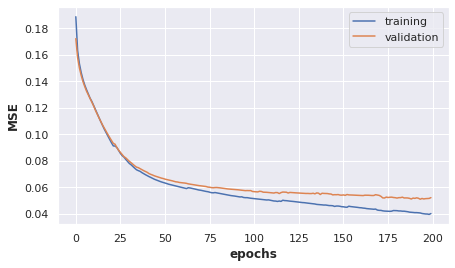

In [34]:
train_losses = [x['train loss'] for x in history]
val_losses = [x['val loss'] for x in history]
sns.set(rc={'figure.figsize':(7,4)})
plt.plot(train_losses, label='training')
plt.plot(val_losses, label='validation')
plt.xlabel("epochs", fontweight='bold')
plt.ylabel("MSE", fontweight='bold')
plt.legend()

In [35]:
evaluate(mlp, testloader, use_cuda)

tensor(0.0411, device='cuda:0', grad_fn=<DivBackward0>)

## Disease Score

In [38]:
def normalize_pandas_column(column):
    return (column - column.mean())/(column.max() - column.min())

In [39]:
disease_scores = pd.DataFrame()

In [40]:
disease_scores['disease_score'] = tvn_features.apply(
    lambda row:
        mlp(Variable(cuda(torch.tensor([row]), use_cuda)).float()).item(), axis=1)
disease_scores['disease_sigmoid_score'] = tvn_features.apply(
    lambda row: torch.sigmoid(
        mlp(Variable(cuda(torch.tensor([row]), use_cuda)).float())).item(), axis=1)

In [41]:
disease_scores.to_csv('scores/disease_score.csv')